In [0]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [0]:
links = ["http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"]


data_dir = 'june3_lab2_data'
if not os.path.exists(data_dir):
  os.mkdir(data_dir)
  
for link in links:
  data = requests.get(link).content
  filename = os.path.join(data_dir, os.path.basename(link))
  with open(filename, "wb") as file:
    file.write(data)

In [0]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex", 
           "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

train_df = pd.read_csv(data_dir+'/adult.data', names = columns, sep = ',', na_values = ' ?')
test_df = pd.read_csv(data_dir+'/adult.test', names = columns, sep = ',', na_values = ' ?', skiprows = 1)

In [4]:
train_df.head(3)

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [5]:
test_df.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.




---

Checking for null values


---



In [6]:
train_df.isnull().sum()

age                  0
workClass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [7]:
test_df.isnull().sum()

age                 0
workClass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

In [8]:
train_df.info(null_counts=True, memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workClass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)

In [9]:
test_df.info(null_counts=True, memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workClass         15318 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education-num     16281 non-null int64
marital-status    16281 non-null object
occupation        15315 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital-gain      16281 non-null int64
capital-loss      16281 non-null int64
hours-per-week    16281 non-null int64
native-country    16007 non-null object
income            16281 non-null object
dtypes: int64(6), object(9)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37723eb240>,
      dtype=object)

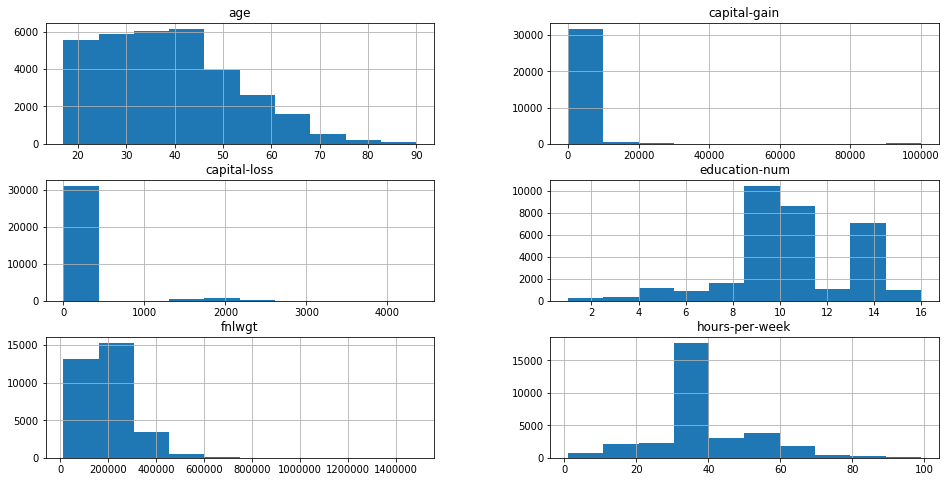

In [10]:
num_feat = train_df.select_dtypes(include=['int'])
print(num_feat.columns)

num_feat.hist(figsize=(16,8))

In [11]:
cat_feat = train_df.select_dtypes(include=['object'])
print(cat_feat.columns)

Index(['workClass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


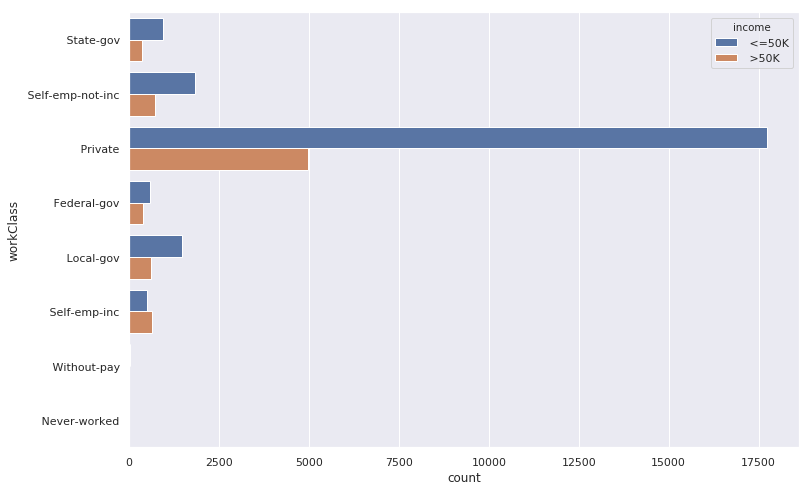

In [12]:
sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(y='workClass', hue='income', data = cat_feat)

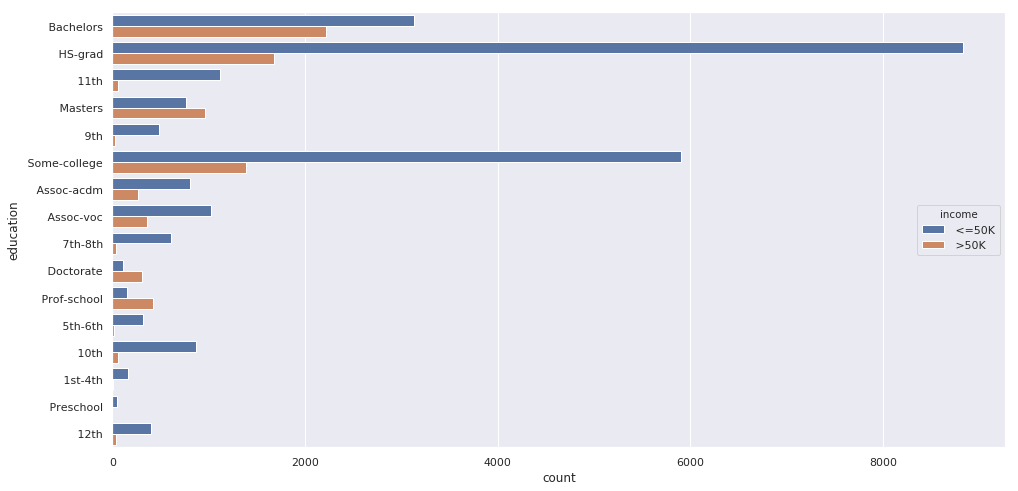

In [13]:
sns.set(rc={'figure.figsize':(16,8)})
sns.countplot(y='education', hue='income', data = cat_feat)

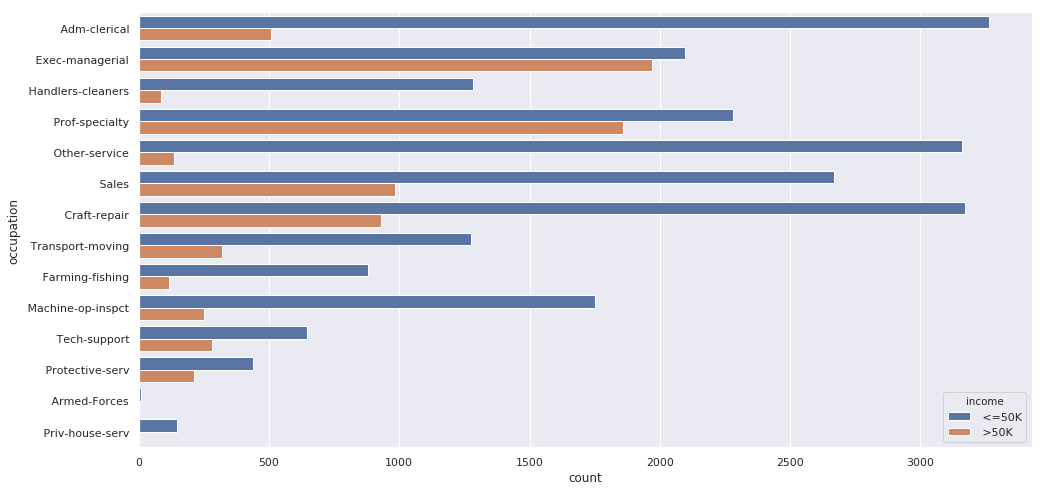

In [14]:
sns.set(rc={'figure.figsize':(16,8)})
sns.countplot(y='occupation', hue='income', data = cat_feat)



---

Preprocessing: Modifying output values to work with Logistic Regression


---



In [0]:
train_df['income'] = train_df['income'].apply(lambda x: 1 if x==' >50K' else 0)
test_df['income'] = test_df['income'].apply(lambda x: 1 if x==' >50K.' else 0)

In [16]:
train_df['income'].tail()

32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, dtype: int64

In [17]:
test_df['income'].tail()

16276    0
16277    0
16278    0
16279    0
16280    1
Name: income, dtype: int64



---

Preprocessing: Imputing null values


---



In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workClass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income            32561 non-null int64
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [0]:
train_df.fillna(train_df.mode().iloc[0], inplace=True)

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workClass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null int64
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [21]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workClass         15318 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education-num     16281 non-null int64
marital-status    16281 non-null object
occupation        15315 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital-gain      16281 non-null int64
capital-loss      16281 non-null int64
hours-per-week    16281 non-null int64
native-country    16007 non-null object
income            16281 non-null int64
dtypes: int64(7), object(8)
memory usage: 1.9+ MB


In [22]:
test_df.fillna(test_df.mode().iloc[0], inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workClass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education-num     16281 non-null int64
marital-status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital-gain      16281 non-null int64
capital-loss      16281 non-null int64
hours-per-week    16281 non-null int64
native-country    16281 non-null object
income            16281 non-null int64
dtypes: int64(7), object(8)
memory usage: 1.9+ MB




---


Preprocessing: One Hot Encoding

---



In [23]:
train_df.columns

Index(['age', 'workClass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [0]:
train_df_y = train_df['income']
train_df.drop('income', axis =1, inplace=True)

test_df_y = test_df['income']
test_df.drop('income', axis =1, inplace=True)

In [25]:
# ensures that the same dummy variable corresponds to the same dimensions in both train and test datasets
df = pd.concat([train_df, test_df], axis=0)
df.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16280
Data columns (total 14 columns):
age               48842 non-null int64
workClass         48842 non-null object
fnlwgt            48842 non-null int64
education         48842 non-null object
education-num     48842 non-null int64
marital-status    48842 non-null object
occupation        48842 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null int64
capital-loss      48842 non-null int64
hours-per-week    48842 non-null int64
native-country    48842 non-null object
dtypes: int64(6), object(8)

In [26]:
cat_feat = df.select_dtypes(include=['object'])
for col in cat_feat.columns:
   print(col, ' ', df[col].nunique())

workClass   8
education   16
marital-status   7
occupation   14
relationship   6
race   5
sex   2
native-country   41


In [27]:
df.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [28]:
for col in cat_feat.columns:
  df  = pd.concat([df, pd.get_dummies(df[col], prefix=col, prefix_sep=':')], axis=1)
  df.drop(col, axis=1, inplace=True)
df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workClass: Federal-gov,workClass: Local-gov,workClass: Never-worked,workClass: Private,workClass: Self-emp-inc,workClass: Self-emp-not-inc,workClass: State-gov,workClass: Without-pay,education: 10th,education: 11th,education: 12th,education: 1st-4th,education: 5th-6th,education: 7th-8th,education: 9th,education: Assoc-acdm,education: Assoc-voc,education: Bachelors,education: Doctorate,education: HS-grad,education: Masters,education: Preschool,education: Prof-school,education: Some-college,marital-status: Divorced,marital-status: Married-AF-spouse,marital-status: Married-civ-spouse,marital-status: Married-spouse-absent,marital-status: Never-married,marital-status: Separated,marital-status: Widowed,occupation: Adm-clerical,occupation: Armed-Forces,occupation: Craft-repair,...,native-country: Canada,native-country: China,native-country: Columbia,native-country: Cuba,native-country: Dominican-Republic,native-country: Ecuador,native-country: El-Salvador,native-country: England,native-country: France,native-country: Germany,native-country: Greece,native-country: Guatemala,native-country: Haiti,native-country: Holand-Netherlands,native-country: Honduras,native-country: Hong,native-country: Hungary,native-country: India,native-country: Iran,native-country: Ireland,native-country: Italy,native-country: Jamaica,native-country: Japan,native-country: Laos,native-country: Mexico,native-country: Nicaragua,native-country: Outlying-US(Guam-USVI-etc),native-country: Peru,native-country: Philippines,native-country: Poland,native-country: Portugal,native-country: Puerto-Rico,native-country: Scotland,native-country: South,native-country: Taiwan,native-country: Thailand,native-country: Trinadad&Tobago,native-country: United-States,native-country: Vietnam,native-country: Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
df.info(verbose=False, memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16280
Columns: 105 entries, age to native-country: Yugoslavia
dtypes: int64(6), uint8(99)

In [30]:
train_df = df.head(train_df.shape[0])
train_df.shape

(32561, 105)

In [31]:
test_df = df.tail(test_df.shape[0])
test_df.shape

(16281, 105)



---

Q1. Standardize your data - For each feature, subtract mean and divide by standard deviation

---



In [0]:
scaler = StandardScaler()
scaler.fit(train_df)
train_df = scaler.transform(train_df)
test_df = scaler.transform(test_df)


---


Q2. Fit a Logistic Regression model onto your data and make predictions using this model


---



In [33]:
model = LogisticRegression(random_state=0)
model.fit(train_df, train_df_y)

pred = model.predict(test_df)
pred

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0, 0, 0, ..., 1, 0, 1])



---

Q3. Use 5-fold stratified cross-validation and predict the mean accuracy for this method


---



In [34]:
%%time
scores = cross_val_score(model, train_df, train_df_y, cv=5)
#solver : str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, optional (default=’liblinear’).

print(scores)
print(np.mean(scores))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[0.84553969 0.84935504 0.85288698 0.85457617 0.85165848]
0.8508032696655452
CPU times: user 14 s, sys: 524 ms, total: 14.5 s
Wall time: 13.9 s




---

Q4.  Inspect the weights of the model you have learnt. Predict its accuracy on the test set.

---



In [35]:
model.coef_

array([[ 3.07461056e-01,  7.29596930e-02,  3.90079505e-01,
         2.34372907e+00,  2.60565331e-01,  3.89232612e-01,
         1.07039489e-01, -1.71346312e-03, -7.35710192e-02,
         2.26811427e-02,  4.92886124e-02, -1.00451677e-01,
        -2.92143261e-02, -1.29809190e-01, -9.17132165e-02,
        -1.14626039e-01, -4.53760623e-02, -3.56843845e-02,
        -3.95591027e-02, -1.03973635e-01, -7.58638470e-02,
        -1.33061852e-02,  1.73820139e-02,  1.52506652e-01,
         1.25503130e-01, -8.41263584e-02,  1.49401156e-01,
        -4.64231267e-01,  1.43019539e-01,  1.44849571e-02,
        -2.21006102e-01,  5.13704640e-02,  7.50539022e-01,
        -7.97599727e-02, -5.34551235e-01, -1.35443732e-01,
        -9.27790435e-02, -4.65121576e-03, -2.11285919e-02,
         2.43632752e-02,  2.44734201e-01, -1.76218956e-01,
        -1.34603358e-01, -6.30145899e-02, -2.48610435e-01,
        -2.72762229e-01,  7.86614351e-02,  6.96789488e-02,
         8.23876545e-02,  1.04066453e-01, -2.21995605e-0

In [36]:
accuracy_score(pred, test_df_y)

0.8505620047908605

[[11592  1590]
 [  843  2256]]


Text(84.5, 0.5, 'Actual classes')

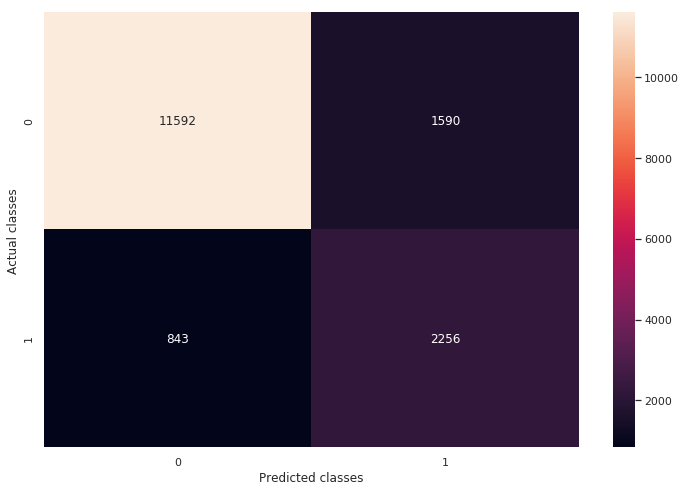

In [37]:
# Here pred contains predictions of your model on the test set and test_df_y contains the actual outcome for the test set

sns.set(rc={'figure.figsize':(12,8)})
conf_mat = confusion_matrix(pred, test_df_y)
sns.heatmap(conf_mat, annot=True, fmt='d')
print(conf_mat)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')



---

Q5. Determine the best parameters for your model using Grid Search. Make predictions and find accuracy on the test set using these parameters.

---



In [0]:
reg = ['l1', 'l2']
C = np.logspace(0, 4, 5)

# creating a dictionary of hyperparameters
hyperpara = dict(C=C, penalty=reg, random_state=[0])


In [39]:
%%time
clf = GridSearchCV(estimator = model, param_grid = hyperpara, cv=3)
best_model = clf.fit(train_df, train_df_y)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Best Penalty: l2
Best C: 1.0
CPU times: user 3min 34s, sys: 3.01 s, total: 3min 37s
Wall time: 3min 33s


In [40]:
best_predicted_values = best_model.predict(test_df)
print(best_predicted_values)

[0 0 0 ... 1 0 1]


In [41]:
accuracy_score(best_predicted_values, test_df_y)


0.8505620047908605